# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

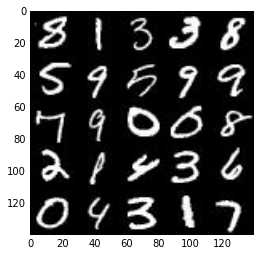

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

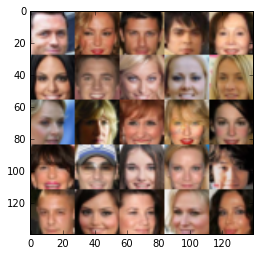

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2 
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    b, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)    
    
    print_every = 10
    show_every = 100 
    losses = []
    n_images = 25
    steps = 0
#     saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})                
                
                if steps % print_every == 0:

                    # At the end of each epoch, get the losses and print them out                    
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z, input_lr:learning_rate})                    
                

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4079... Generator Loss: 1.3884
Epoch 1/2... Discriminator Loss: 2.7400... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 3.1225... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 0.3423... Generator Loss: 2.3670
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.8849
Epoch 1/2... Discriminator Loss: 2.4363... Generator Loss: 0.2379
Epoch 1/2... Discriminator Loss: 0.9132... Generator Loss: 1.0542
Epoch 1/2... Discriminator Loss: 1.9714... Generator Loss: 3.7808
Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.3437


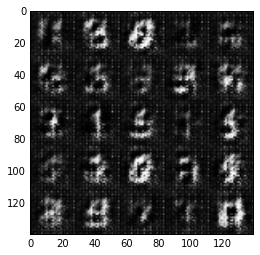

Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 2.7503
Epoch 1/2... Discriminator Loss: 0.7633... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 2.8972... Generator Loss: 3.9679
Epoch 1/2... Discriminator Loss: 2.1912... Generator Loss: 0.2588
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 2.9436
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 0.2864
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 1.2007


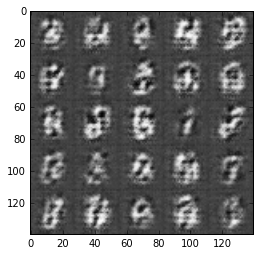

Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.3464
Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.3686
Epoch 1/2... Discriminator Loss: 0.3330... Generator Loss: 3.7351
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 0.4033... Generator Loss: 1.7538
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.5009
Epoch 1/2... Discriminator Loss: 2.3007... Generator Loss: 0.6990


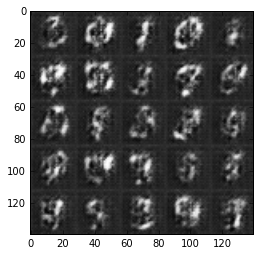

Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 0.5019
Epoch 1/2... Discriminator Loss: 0.5582... Generator Loss: 1.3076
Epoch 1/2... Discriminator Loss: 0.3034... Generator Loss: 1.7307
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 0.1835... Generator Loss: 3.0264
Epoch 1/2... Discriminator Loss: 0.4337... Generator Loss: 1.3187
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 1.3224


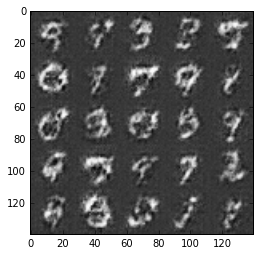

Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.7611... Generator Loss: 0.2336
Epoch 1/2... Discriminator Loss: 1.5845... Generator Loss: 0.3273
Epoch 1/2... Discriminator Loss: 0.6953... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 0.1695... Generator Loss: 2.8404
Epoch 1/2... Discriminator Loss: 0.2221... Generator Loss: 2.1124
Epoch 1/2... Discriminator Loss: 0.5462... Generator Loss: 1.2122
Epoch 1/2... Discriminator Loss: 0.2321... Generator Loss: 1.8905


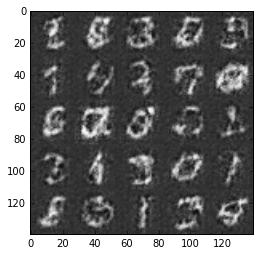

Epoch 1/2... Discriminator Loss: 0.2243... Generator Loss: 3.2614
Epoch 1/2... Discriminator Loss: 0.7900... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 2.4299... Generator Loss: 0.2434
Epoch 1/2... Discriminator Loss: 1.7601... Generator Loss: 2.5614
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 0.3959... Generator Loss: 1.6306
Epoch 1/2... Discriminator Loss: 0.6056... Generator Loss: 2.2801
Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 1.4483
Epoch 1/2... Discriminator Loss: 0.1257... Generator Loss: 2.8482
Epoch 1/2... Discriminator Loss: 0.2104... Generator Loss: 2.6834


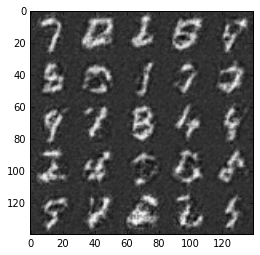

Epoch 1/2... Discriminator Loss: 0.0927... Generator Loss: 3.6954
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 0.0554... Generator Loss: 3.9858
Epoch 1/2... Discriminator Loss: 0.0848... Generator Loss: 3.4639
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 2.2948
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.3746
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 0.8302
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 0.6711
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.4613


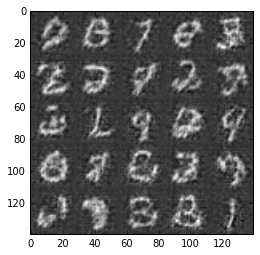

Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 0.6306
Epoch 1/2... Discriminator Loss: 0.1495... Generator Loss: 2.4990
Epoch 1/2... Discriminator Loss: 0.1341... Generator Loss: 4.9902
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 0.7101... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 0.0733... Generator Loss: 5.3974
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 4.1858
Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 0.9369
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 2.0771


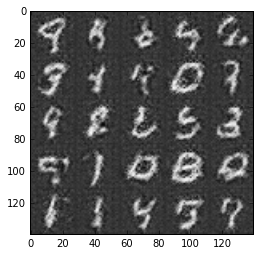

Epoch 1/2... Discriminator Loss: 0.4713... Generator Loss: 1.1822
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 0.5850
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 0.2553... Generator Loss: 1.7946
Epoch 1/2... Discriminator Loss: 1.7303... Generator Loss: 0.2455
Epoch 1/2... Discriminator Loss: 0.1338... Generator Loss: 2.3747
Epoch 1/2... Discriminator Loss: 0.4004... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 0.2225... Generator Loss: 1.8986
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 4.0228


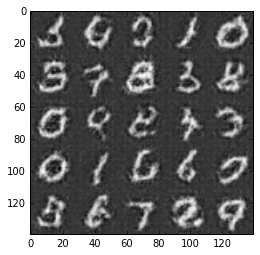

Epoch 1/2... Discriminator Loss: 0.0723... Generator Loss: 3.1377
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 4.1949
Epoch 1/2... Discriminator Loss: 1.8340... Generator Loss: 4.0667
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.3924
Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 1.5680
Epoch 2/2... Discriminator Loss: 0.1924... Generator Loss: 2.0309
Epoch 2/2... Discriminator Loss: 0.1263... Generator Loss: 2.5607
Epoch 2/2... Discriminator Loss: 0.1152... Generator Loss: 2.7671
Epoch 2/2... Discriminator Loss: 0.3259... Generator Loss: 2.6611


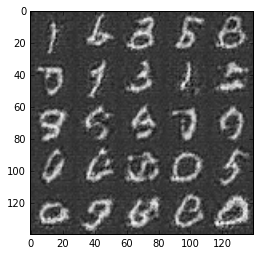

Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 2.1650
Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 2.1986... Generator Loss: 0.1558
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 0.5032... Generator Loss: 1.3178
Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 0.5857... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 0.1441... Generator Loss: 2.4764
Epoch 2/2... Discriminator Loss: 0.2047... Generator Loss: 1.9621
Epoch 2/2... Discriminator Loss: 0.0322... Generator Loss: 5.2576


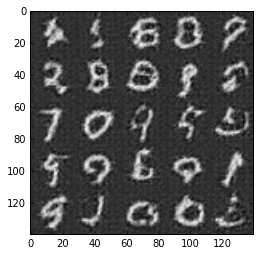

Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.0826
Epoch 2/2... Discriminator Loss: 0.3310... Generator Loss: 1.4431
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 0.0175... Generator Loss: 6.6851
Epoch 2/2... Discriminator Loss: 0.2076... Generator Loss: 1.9021
Epoch 2/2... Discriminator Loss: 0.0331... Generator Loss: 5.7884
Epoch 2/2... Discriminator Loss: 0.1985... Generator Loss: 2.0558
Epoch 2/2... Discriminator Loss: 0.1700... Generator Loss: 2.1390
Epoch 2/2... Discriminator Loss: 0.0441... Generator Loss: 7.1170
Epoch 2/2... Discriminator Loss: 0.0246... Generator Loss: 5.4645


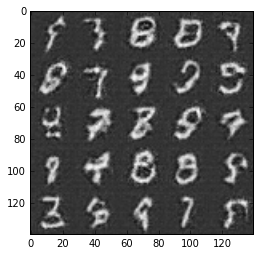

Epoch 2/2... Discriminator Loss: 0.1748... Generator Loss: 2.2403
Epoch 2/2... Discriminator Loss: 0.1401... Generator Loss: 2.2709
Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 1.3374
Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 1.6071
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.3355
Epoch 2/2... Discriminator Loss: 2.7508... Generator Loss: 0.1159
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.4198
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.4229
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.1908


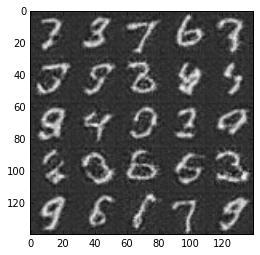

Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.5008
Epoch 2/2... Discriminator Loss: 0.4874... Generator Loss: 1.8843
Epoch 2/2... Discriminator Loss: 0.5460... Generator Loss: 1.2468
Epoch 2/2... Discriminator Loss: 0.4830... Generator Loss: 1.2120
Epoch 2/2... Discriminator Loss: 0.3231... Generator Loss: 1.7852
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 1.5403
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.1089


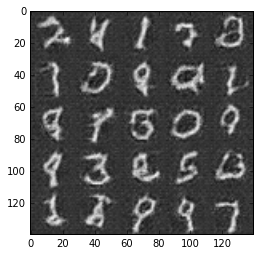

Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 0.9114
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.6607... Generator Loss: 0.2667
Epoch 2/2... Discriminator Loss: 1.7106... Generator Loss: 0.3138
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.4210
Epoch 2/2... Discriminator Loss: 0.2254... Generator Loss: 1.9808
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.6171
Epoch 2/2... Discriminator Loss: 0.3983... Generator Loss: 1.3898
Epoch 2/2... Discriminator Loss: 0.5056... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.2164... Generator Loss: 2.1120


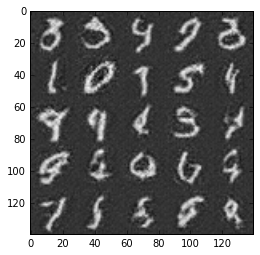

Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 0.6607
Epoch 2/2... Discriminator Loss: 0.6842... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 0.5930
Epoch 2/2... Discriminator Loss: 0.1198... Generator Loss: 2.7281
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 1.4455
Epoch 2/2... Discriminator Loss: 0.1983... Generator Loss: 2.0131
Epoch 2/2... Discriminator Loss: 0.7941... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 0.0805... Generator Loss: 2.9574
Epoch 2/2... Discriminator Loss: 1.2612... Generator Loss: 0.4164


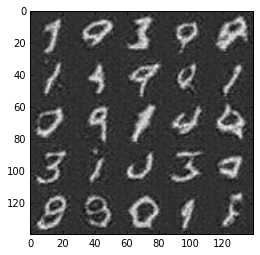

Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.5167
Epoch 2/2... Discriminator Loss: 0.0582... Generator Loss: 4.5214
Epoch 2/2... Discriminator Loss: 0.6064... Generator Loss: 0.9735
Epoch 2/2... Discriminator Loss: 0.0509... Generator Loss: 4.0550
Epoch 2/2... Discriminator Loss: 0.5775... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 0.0723... Generator Loss: 3.2809
Epoch 2/2... Discriminator Loss: 0.2066... Generator Loss: 2.0288
Epoch 2/2... Discriminator Loss: 0.0324... Generator Loss: 4.1104
Epoch 2/2... Discriminator Loss: 0.4820... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 0.0291... Generator Loss: 4.3263


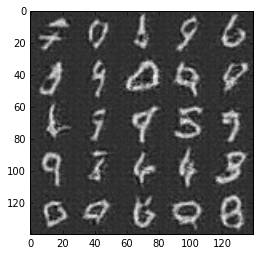

Epoch 2/2... Discriminator Loss: 0.2488... Generator Loss: 2.3906
Epoch 2/2... Discriminator Loss: 2.3838... Generator Loss: 1.7825
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 0.9175
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 0.8560


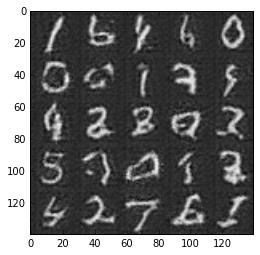

Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 0.5770
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 1.5828
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.3926


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 5.8326
Epoch 1/1... Discriminator Loss: 2.1906... Generator Loss: 5.5176
Epoch 1/1... Discriminator Loss: 3.0533... Generator Loss: 7.5058
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 2.4381... Generator Loss: 0.1117
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 2.1919
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 8.0856
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 0.9349


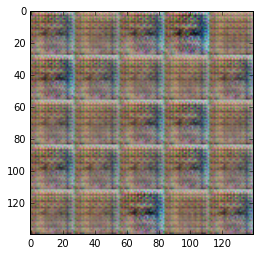

Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 3.4125
Epoch 1/1... Discriminator Loss: 2.2306... Generator Loss: 0.2209
Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 2.2973... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 2.2304... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.9842


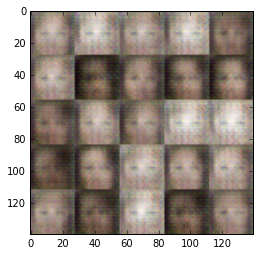

Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 2.3809... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.8763... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6934


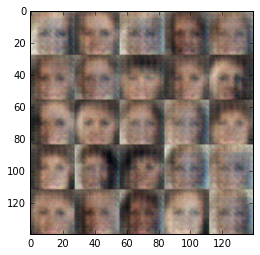

Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.6607... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.6733


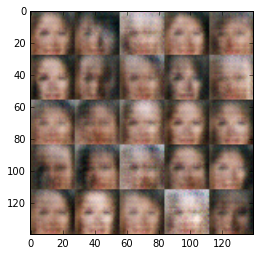

Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.6470


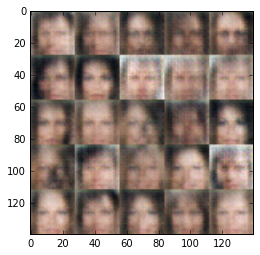

Epoch 1/1... Discriminator Loss: 1.6612... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.7731... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.6834


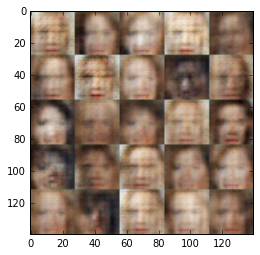

Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.8053... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.7550... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5791


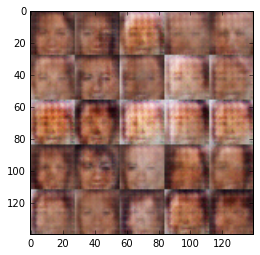

Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6498


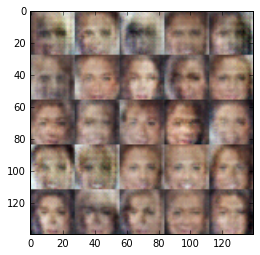

Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6856


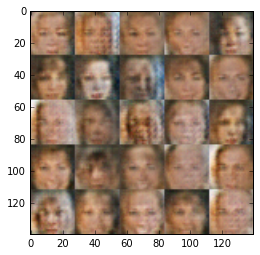

Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5960


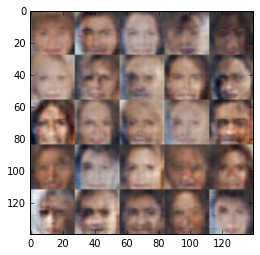

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 2.1425
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.9277... Generator Loss: 0.1963
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6831


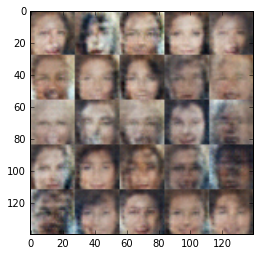

Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7713


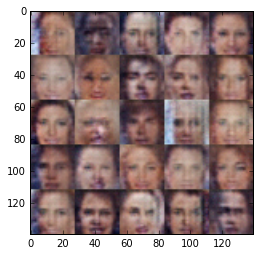

Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.6877... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8475


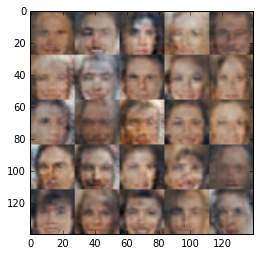

Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.3556
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.8038... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.6648... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.5654


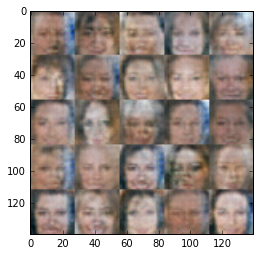

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 2.2722
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.6912... Generator Loss: 0.2978
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 2.3836
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.5373


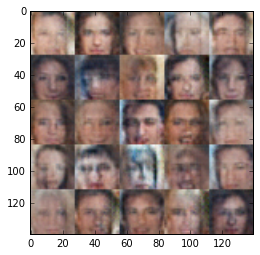

Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 1.7623... Generator Loss: 0.2323
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.8547
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9640


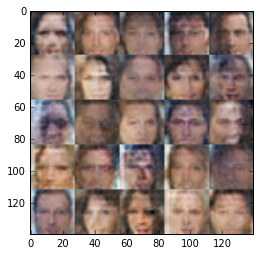

Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 2.1025
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.6732... Generator Loss: 0.2610
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.2639
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.4054
Epoch 1/1... Discriminator Loss: 1.7068... Generator Loss: 0.9375


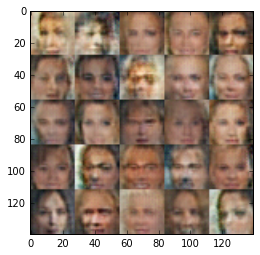

Epoch 1/1... Discriminator Loss: 1.6603... Generator Loss: 0.3252
Epoch 1/1... Discriminator Loss: 1.6927... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 3.7717... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.7766... Generator Loss: 0.3019
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.5840


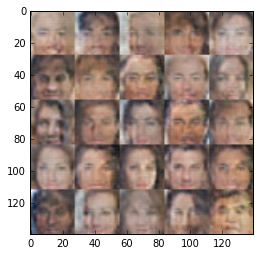

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.4734
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 0.3040
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8251


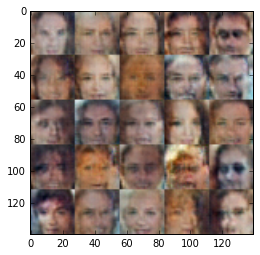

Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 1.7095... Generator Loss: 0.3190
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.8315


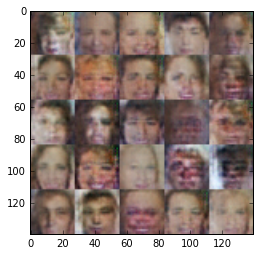

Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.8960... Generator Loss: 0.2139
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.4513
Epoch 1/1... Discriminator Loss: 2.1176... Generator Loss: 0.2051
Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 0.4207
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.5246


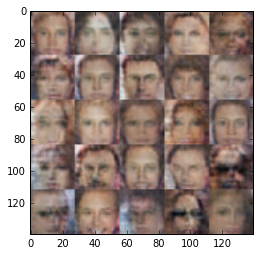

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.5708


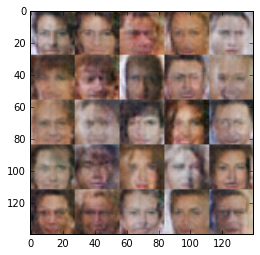

Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 1.7120... Generator Loss: 0.2875
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.8784... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.4347


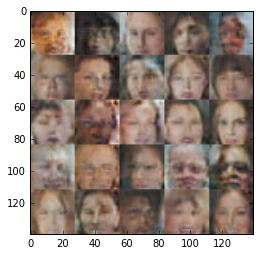

Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.9455... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.3043


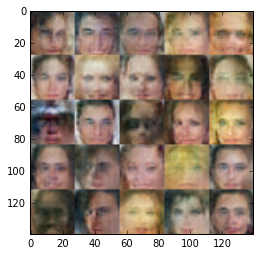

Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.7552


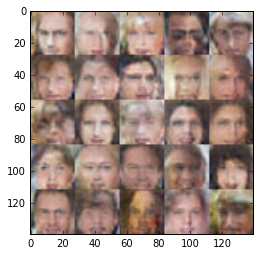

Epoch 1/1... Discriminator Loss: 1.8471... Generator Loss: 0.2337
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.3577
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.3099
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.3840
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.3222


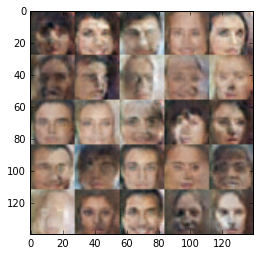

Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.5102


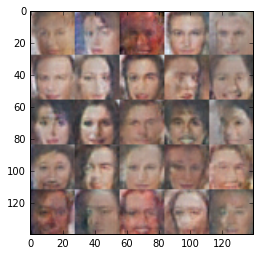

Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.3366
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.3012


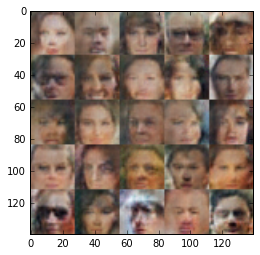

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.4607


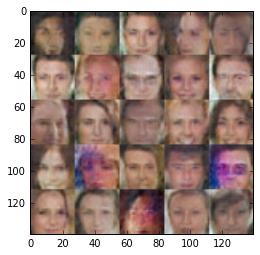

Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.3084
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.7604... Generator Loss: 1.8594
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.6411... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7825


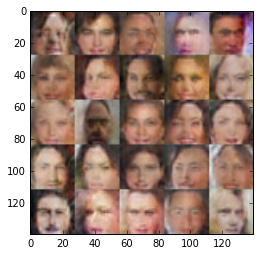

Epoch 1/1... Discriminator Loss: 1.8199... Generator Loss: 0.2261
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.6297... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.4847


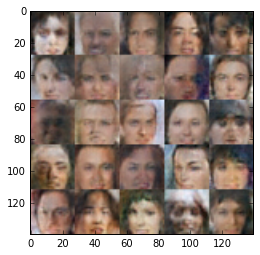

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9822


In [18]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.